In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from torch_wavefunction import *

Using device: cuda


In [6]:
class WavefunctionResults:
    def __init__(self):
        self.wavefunctions = []
        self.convergence_energies = []
        self.final_wavefunctions = []
        self.final_energies = []
        self.torch_wavefunctions = []

In [ ]:
def train_single_state(results: WavefunctionResults, x_train,layout=[1,60,60,1], **kwargs):
    model = WaveFunctionMLP(layout).to(device)
    
    if "callback" in kwargs:
        callback_kwargs = kwargs["callback"]
        assert isinstance(callback_kwargs, dict), "callback_kwargs must be a dictionary"
    else:
        callback_kwargs = {}
    if "train" in kwargs:
        train_kwargs = kwargs["train"]
        assert isinstance(train_kwargs, dict), "train_kwargs must be a dictionary"
    else:
        train_kwargs = {}
    
    
    for key in kwargs:
        if ((key != "callback") and (key != "train")):
            print(f"Unknown keyword argument: {key}")
    
    if "patience" not in callback_kwargs:
        callback_kwargs['patience'] = 250
    if "min_delta" not in callback_kwargs:
        callback_kwargs['min_delta'] = 0.0001
        
    if "lr" not in train_kwargs:
        train_kwargs['lr'] = 0.001
    if "epochs" not in train_kwargs:
        train_kwargs['epochs'] = 1000
    if "save_wavefunction_history" not in train_kwargs:
        train_kwargs['save_wavefunction_history'] = False
    # if "save_energy_history" not in train_kwargs:
    #     train_kwargs['save_energy_history'] = False
    if "previous_wavefunctions" not in train_kwargs:
        train_kwargs['previous_wavefunctions'] = None
    
    early_stopping = EarlyStoppingCallback(patience = callback_kwargs['patience'], min_delta =  callback_kwargs['min_delta'])
    psi_normalized_cpu, energy_fin, energy_hist, wf_hist, psi_normalized_torch = train_wavefunction(model, 
                                                                                                    x_train, 
                                                                                                    callback=early_stopping, 
                                                                                                    **train_kwargs)
    results.wavefunctions.append(wf_hist)
    results.convergence_energies.append(energy_hist)
    results.final_wavefunctions.append(psi_normalized_cpu)
    results.final_energies.append(energy_fin)
    results.torch_wavefunctions.append(psi_normalized_torch)
    return psi_normalized, energy_fin, energy_hist_0, wf_hist_0, psi_normalized_torch
        

Epoch 0: Energy = 16.394445
Epoch 100: Energy = 0.574808
Epoch 200: Energy = 0.510157
Epoch 300: Energy = 0.504380
Epoch 400: Energy = 0.502455
Epoch 500: Energy = 0.501823
Epoch 600: Energy = 0.501561
Epoch 700: Energy = 0.501426
Epoch 800: Energy = 0.501267
Epoch 900: Energy = 0.501188
Epoch 0: Energy = 19.557812
Epoch 100: Energy = 2.207255
Epoch 200: Energy = 1.669145
Epoch 300: Energy = 1.565170
Epoch 400: Energy = 1.535706
Epoch 500: Energy = 1.543078
Epoch 600: Energy = 1.523891
Epoch 700: Energy = 1.515225
Epoch 800: Energy = 1.510139
Epoch 900: Energy = 1.544415
Epoch 1000: Energy = 1.506339
Epoch 1100: Energy = 1.525806
Epoch 1200: Energy = 1.504465
Epoch 1300: Energy = 1.503189
Epoch 1400: Energy = 1.506396
Epoch 1500: Energy = 1.502435
Epoch 1600: Energy = 1.501817
Epoch 1700: Energy = 1.502603
Epoch 1800: Energy = 1.501456
Epoch 1900: Energy = 1.509967
Epoch 2000: Energy = 1.501242
Epoch 2100: Energy = 1.500950
Epoch 2200: Energy = 1.505119
Epoch 2300: Energy = 1.500848
Ep

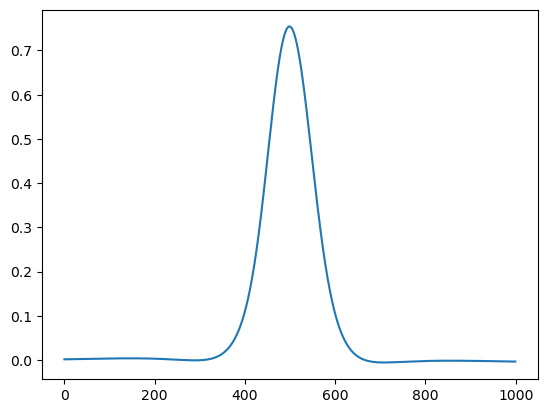

In [66]:
x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device).view(-1, 1)
x_train.requires_grad = True
results = WavefunctionResults()

callback_kwargs_0 = {
    "patience": 250,
    "min_delta": 1e-5,
    }
train_kwargs_0 = {
    "lr": 0.001,
    "epochs": 1000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": None,
    }

options_0 = {
    "callback": callback_kwargs_0,
    "train": train_kwargs_0,
    }

train_single_state(results, x_train, layout=[1,60,60,1], **options_0)

plt.plot(results.final_wavefunctions[0])

callback_kwargs_1 = {
    "patience": 300,
    "min_delta": 1e-4,
    }

train_kwargs_1 = {
    "lr": 0.001,
    "epochs": 10_000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": results.torch_wavefunctions,
    }
options_1 = {
    "callback": callback_kwargs_1,
    "train": train_kwargs_1,
    }

train_single_state(results, x_train, layout=[1,80,80,80,1], **options_1)

callback_kwargs_2 = {
    "patience": 400,
    "min_delta": 1e-4,
    }

train_kwargs_2 = {
    "lr": 0.001,
    "epochs": 10_000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": results.torch_wavefunctions,
    }

options_2 = {
    "callback": callback_kwargs_2,
    "train": train_kwargs_2,
    }
train_single_state(results, x_train, layout=[1,80,80,80,1], **options_2)

callback_kwargs_3 = {
    "patience": 500,
    "min_delta": 1e-4,
    }

train_kwargs_3 = {
    "lr": 0.001,
    "epochs": 10_000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": results.torch_wavefunctions,
    }

options_3 = {
    "callback": callback_kwargs_3,
    "train": train_kwargs_3,
    }

train_single_state(results, x_train, layout=[1,80,80,80,80,1], **options_3);

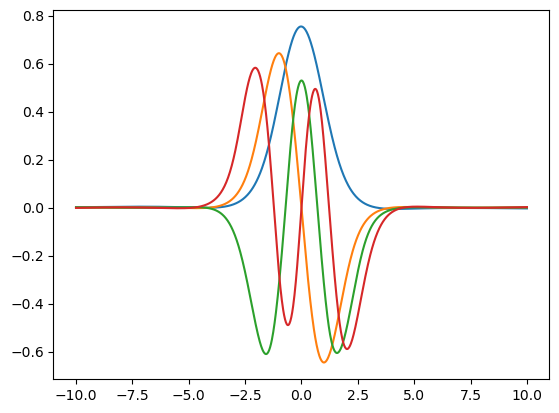

In [67]:
for final_wavefunction_cpu in results.final_wavefunctions:
    plt.plot(x_train.cpu().detach().numpy(), final_wavefunction_cpu, label="Final Wavefunction CPU")

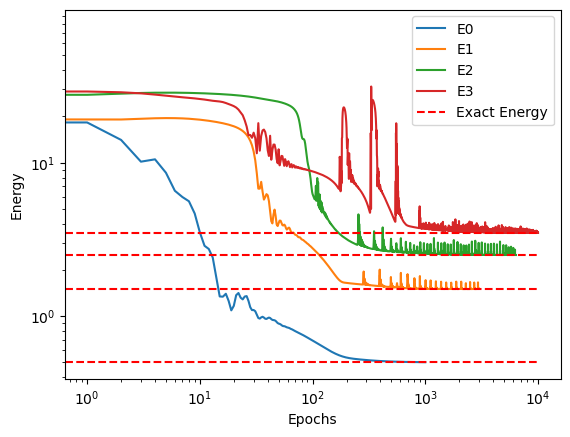

In [49]:
for i, energy_hist in enumerate(results.convergence_energies):
    plt.plot(energy_hist, label=f"E{i}")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.hlines([(0.5+n) for n in range(i+1)], 0, 10000, colors='r', linestyles='dashed', label="Exact Energy")
plt.loglog()
plt.legend()

Epoch 0: Energy = 17.071930
Epoch 100: Energy = 0.640427
Epoch 200: Energy = 0.530935
Epoch 300: Energy = 0.510657
Epoch 400: Energy = 0.504674
Epoch 500: Energy = 0.502651
Epoch 600: Energy = 0.501870
Epoch 700: Energy = 0.501467
Epoch 800: Energy = 0.501205
Epoch 900: Energy = 0.501022
Epoch 0: Energy = 30.805498
Epoch 100: Energy = 2.789145
Epoch 200: Energy = 2.434894
Epoch 300: Energy = 1.575254
Epoch 400: Energy = 1.556427
Epoch 500: Energy = 1.541891
Epoch 600: Energy = 1.530777
Epoch 700: Energy = 1.522280
Epoch 800: Energy = 1.519530
Epoch 900: Energy = 1.533293
Epoch 1000: Energy = 1.511236
Epoch 1100: Energy = 1.509210
Epoch 1200: Energy = 1.507863
Epoch 1300: Energy = 1.507034
Epoch 1400: Energy = 1.510278
Epoch 1500: Energy = 1.504804
Epoch 1600: Energy = 1.504546
Epoch 1700: Energy = 1.529844
Epoch 1800: Energy = 1.503331
Epoch 1900: Energy = 1.504339
Epoch 2000: Energy = 1.502561
Epoch 2100: Energy = 1.502643
Epoch 2200: Energy = 1.502046
Epoch 2300: Energy = 1.502100
Ep

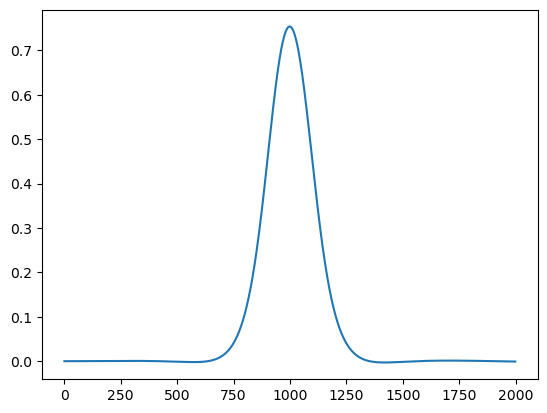

In [50]:
x_train = torch.linspace(-10, 10, 2000, dtype=torch.float32, device=device).view(-1, 1)
x_train.requires_grad = True
results = WavefunctionResults()

callback_kwargs_0 = {
    "patience": 250,
    "min_delta": 1e-5,
    }
train_kwargs_0 = {
    "lr": 0.001,
    "epochs": 1000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": None,
    }

options_0 = {
    "callback": callback_kwargs_0,
    "train": train_kwargs_0,
    }

train_single_state(results, x_train, layout=[1,60,60,1], **options_0)

plt.plot(results.final_wavefunctions[0])

callback_kwargs_1 = {
    "patience": 300,
    "min_delta": 1e-4,
    }

train_kwargs_1 = {
    "lr": 0.001,
    "epochs": 10_000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": results.torch_wavefunctions,
    }
options_1 = {
    "callback": callback_kwargs_1,
    "train": train_kwargs_1,
    }

train_single_state(results, x_train, layout=[1,80,80,80,1], **options_1)

callback_kwargs_2 = {
    "patience": 400,
    "min_delta": 1e-4,
    }

train_kwargs_2 = {
    "lr": 0.001,
    "epochs": 10_000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": results.torch_wavefunctions,
    }

options_2 = {
    "callback": callback_kwargs_2,
    "train": train_kwargs_2,
    }
train_single_state(results, x_train, layout=[1,80,80,80,1], **options_2)

callback_kwargs_3 = {
    "patience": 500,
    "min_delta": 1e-4,
    }

train_kwargs_3 = {
    "lr": 0.001,
    "epochs": 10_000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": results.torch_wavefunctions,
    }

options_3 = {
    "callback": callback_kwargs_3,
    "train": train_kwargs_3,
    }

train_single_state(results, x_train, layout=[1,80,80,80,1], **options_3);

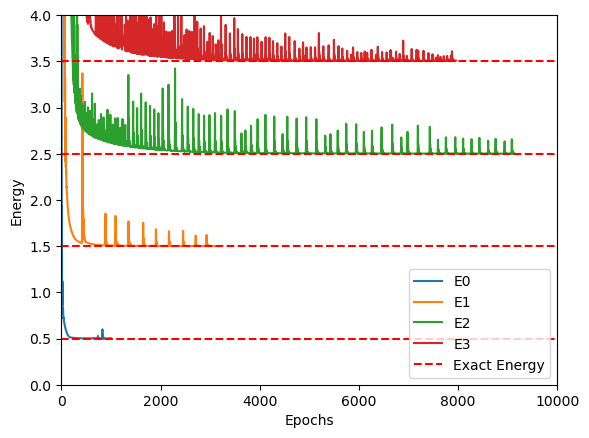

In [68]:
for i, energy_hist in enumerate(results.convergence_energies):
    plt.plot(energy_hist, label=f"E{i}")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.hlines([(0.5+n) for n in range(i+1)], 0, 10000, colors='r', linestyles='dashed', label="Exact Energy")
# plt.semilogx()
plt.ylim([0,4])
plt.xlim([0, 1e4])
plt.legend()

In [75]:
def exact_solution(x,n):
        hermite_poly = hermite(n)
        coeff = np.sqrt(1 / (2**n * factorial(n))) * (1 / np.pi)**0.25
        return coeff * np.exp(-0.5*x**2) * hermite_poly(x)
    
def exact_energy(n):
    return n + 0.5

import matplotlib.animation as animation

def generate_anim(wave_function_history, x_train, n=0, filename="wavefunction_animation.gif"):
    fig, ax = plt.subplots()
    print(f"Wavefunction history size: {len(wave_function_history)}")
    psi_exact = exact_solution(x_train.cpu().numpy(), n)
    
    ax.plot(x_train.cpu().numpy(), np_abs2(psi_exact), label="Exact Solution", linestyle='--', color="#666666", linewidth=1)
    line, = ax.plot(x_train.cpu().numpy(), np_abs2(wave_function_history[0]), label="NQS", color="orange")
    ax.set_ylim(-0.1, 0.65)
    ax.set_ylabel("|ψ|²")
    ax.set_xlabel("x")
    ax.legend()
    def update(frame):
        line.set_ydata(np_abs2(wave_function_history[frame]))
        ax.set_title(f"Epoch {frame*10}, Energy: {results.convergence_energies[n][frame]:.4f}")
        return line,
    plt.close(fig)  # Close the figure to prevent it from displaying immediately
    FFwriter = animation.FFMpegWriter(fps=10)

    ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
    #save as video
    ani.save(filename, writer=FFwriter)#, fps=10)
    
    # ani.save(filename, writer='pillow', fps=10)

with torch.no_grad():
    generate_anim(results.wavefunctions[3], x_train, n=3, filename="3rd.mp4")

Wavefunction history size: 797


## Old code

In [60]:
x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device).view(-1, 1)
x_train.requires_grad = True
model = WaveFunctionMLP().to(device)
early_stopping = EarlyStoppingCallback(patience=250, min_delta=1e-5)
psi_normalized, energy_fin, energy_hist_0, wf_hist_0, psi_normalized_torch = train_wavefunction(model, x_train, epochs=1000, save_wavefunction_history=True, callback=early_stopping)
model2 = WaveFunctionMLP([1,80,80,80,1]).to(device)
early_stopping = EarlyStoppingCallback(patience=300, min_delta=1e-4)
psi_normalized_2, energy_fin_2, energy_hist_1, wave_function_history,psi1_normalized_torch = train_wavefunction(model2, x_train, lr=0.001, previous_wavefunctions=[psi_normalized_torch], epochs=10000, callback=early_stopping, save_wavefunction_history=True,)
early_stopping = EarlyStoppingCallback(patience=400, min_delta=1e-4)
psi_normalized_3, energy_fin_3, energy_hist_2, wave_function_history_2,psi2_normalized_torch = train_wavefunction(model2, x_train, lr=0.001, previous_wavefunctions=[psi_normalized_torch, psi1_normalized_torch], epochs=10000, callback=early_stopping, save_wavefunction_history=True,)
def analytic_solution(x):
    return (1/np.pi)**0.25 * np.exp(-0.5*x**2)
def np_abs2(x):
    """Compute the absolute square of a complex number."""
    return np.real(np.real(x)**2 + np.imag(x)**2)

def torch_analytic_solution(x):
    return (1/np.pi)**0.25 * torch.exp(-0.5*x**2)

with torch.no_grad():
    
    def exact_solution(x,n):
        hermite_poly = hermite(n)
        coeff = np.sqrt(1 / (2**n * factorial(n))) * (1 / np.pi)**0.25
        return coeff * np.exp(-0.5*x**2) * hermite_poly(x)
    
    def exact_energy(n):
        return n + 0.5
    
    import matplotlib.animation as animation
    
    def generate_anim(wave_function_history, x_train, n=0, filename="wavefunction_animation.gif"):
        fig, ax = plt.subplots()
        print(f"Wavefunction history size: {len(wave_function_history)}")
        psi_exact = exact_solution(x_train.cpu().numpy(), n)
        
        ax.plot(x_train.cpu().numpy(), np_abs2(psi_exact), label="Exact Solution", linestyle='--', color="#666666", linewidth=1)
        line, = ax.plot(x_train.cpu().numpy(), np_abs2(wave_function_history[0]), label="NQS", color="orange")
        ax.set_ylim(-0.1, 0.65)
        ax.set_ylabel("|ψ|²")
        ax.set_xlabel("x")
        ax.legend()
        def update(frame):
            line.set_ydata(np_abs2(wave_function_history[frame]))
            ax.set_title(f"Epoch {frame*10}")
            return line,
        plt.close(fig)  # Close the figure to prevent it from displaying immediately

        ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
        ani.save(filename, writer='pillow', fps=10)
        
    generate_anim(wf_hist_0, x_train, n=0, filename="GS.gif")
    generate_anim(wave_function_history, x_train,n=1, filename="1st.gif")
    generate_anim(wave_function_history_2, x_train,n=2, filename="2nd.gif")

    def generate_energy_plot(energy_hists):
        for i, energy_hist in enumerate(energy_hists):
            plt.plot(energy_hist, label=f"{i}")
            plt.hlines([exact_energy(i) for i in range(len(energy_hists))], color='red', linestyle='--', label="Exact Energies", xmin=0, xmax=len(energy_hist))
        plt.xlabel("Epoch")
        plt.ylabel("Energy")
        plt.title("Energy Convergence")
        plt.loglog()
        plt.legend()
        plt.show()
    generate_energy_plot([energy_hist_0, energy_hist_1, energy_hist_2])
    
    
    
    final_wavefunction = model(x_train)
    normalization = torch.sqrt(torch.trapz(torch_abs2(final_wavefunction), x_train,dim=0))
    
    final_wavefunction /= normalization
    final_wavefunction_cpu = final_wavefunction.cpu().numpy()
    
    probability_density = torch_abs2(final_wavefunction).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(x_train.cpu().numpy(), psi_normalized, label="Probability Density")
    plt.plot(x_train.cpu().numpy(), psi_normalized_2, label="Probability Density 2")
    plt.plot(x_train.cpu().numpy(), psi_normalized_3, label="Probability Density 3")
    plt.xlabel("x")
    plt.ylabel("Wavefunction")
    plt.title("Wavefunction History")
    plt.subplot(1,2,2)
    plt.plot(energy_hist_1, label="Energy History")
    plt.xlabel("Epoch")
    plt.ylabel("Energy")
    plt.plot(energy_hist_0, label="Energy History 0")
    plt.title("Energy Convergence")
    
    plt.show()

Epoch 0: Energy = 21.383469
Epoch 100: Energy = 0.518134
Epoch 200: Energy = 0.503900
Epoch 300: Energy = 0.501484
Epoch 400: Energy = 0.500718
Epoch 500: Energy = 0.500460
Epoch 600: Energy = 0.500347
Epoch 700: Energy = 0.500289
Epoch 800: Energy = 0.500252
Epoch 900: Energy = 0.500224
Epoch 0: Energy = 22.129440
Epoch 100: Energy = 3.130845
Epoch 200: Energy = 1.811192
Epoch 300: Energy = 1.671894
Epoch 400: Energy = 1.602432


KeyboardInterrupt: 

## RBM

/home/pfargas/Desktop/PhD/1D-Variational-RBM/python/torch_wavefunction.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.b = nn.Parameter(torch.tensor(params["b"], dtype=self.type_var, device=device))
/home/pfargas/Desktop/PhD/1D-Variational-RBM/python/torch_wavefunction.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.c = nn.Parameter(torch.tensor(params["c"], dtype=self.type_var, device=device))
/home/pfargas/Desktop/PhD/1D-Variational-RBM/python/torch_wavefunction.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  se

Epoch 0: Energy = 3.831209
Epoch 100: Energy = 0.536048
Epoch 200: Energy = 0.515548
Epoch 300: Energy = 0.509511
Epoch 400: Energy = 0.506534
Epoch 500: Energy = 0.504791
Epoch 600: Energy = 0.503672
Epoch 700: Energy = 0.502907
Epoch 800: Energy = 0.502358
Epoch 900: Energy = 0.501950
Epoch 0: Energy = 47.333875
Epoch 100: Energy = 47.198348
Epoch 200: Energy = 47.047676
Epoch 300: Energy = 46.899190
Epoch 400: Energy = 46.768398
Epoch 500: Energy = 46.664420
Epoch 600: Energy = 46.589223
Epoch 700: Energy = 46.539476
Epoch 800: Energy = 46.509243
Epoch 900: Energy = 46.492315
Epoch 1000: Energy = 46.483550
Epoch 1100: Energy = 46.479320
Epoch 1200: Energy = 46.477425
Epoch 1300: Energy = 46.476583
Epoch 1400: Energy = 46.476199
Epoch 1500: Energy = 46.475961
Epoch 1600: Energy = 46.475738
Epoch 1700: Energy = 46.475481
Epoch 1800: Energy = 46.475133
Epoch 1900: Energy = 46.474657
Epoch 2000: Energy = 46.473930
Epoch 2100: Energy = 46.472855
Epoch 2200: Energy = 46.471251
Epoch 2300:

/home/pfargas/software/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/pfargas/software/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


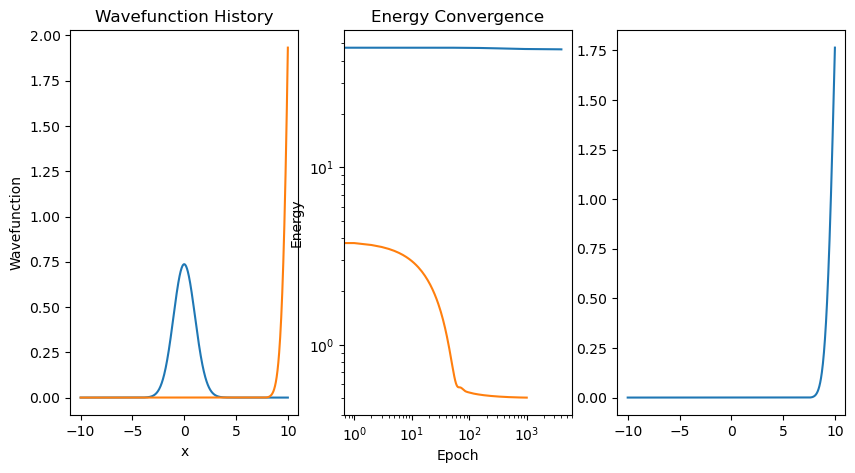

In [3]:
Nh = 10
params = {
    "b": torch.randn(1, dtype=torch.float32, device=device),
    "c": torch.randn(Nh, dtype=torch.float32, device=device),
    "w": torch.randn(Nh, dtype=torch.float32, device=device),
    "Nh": Nh,
    "is_complex": False
}
model = WaveFunctionNN(params).to(device)

x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device)
x_train.requires_grad = True

psi_normalized, energy_fin, energy_hist_0, _, psi_normalized_torch = train_wavefunction(model, x_train)

complex_type = torch.complex128
Nh = 40
params = {
    "b": torch.randn(1, dtype=complex_type, device=device),
    "c": torch.randn(Nh, dtype=torch.float32, device=device)+1j*torch.zeros(Nh, dtype=torch.float32, device=device),
    "w": torch.randn(Nh, dtype=torch.float32, device=device)+1j*torch.zeros(Nh, dtype=torch.float32, device=device),
    "Nh": Nh,
    "is_complex": True
}
model = WaveFunctionNN(params).to(device)

x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device)
x_train.requires_grad = True
psi_normalized_2, energy_fin_2, energy_hist_1, wave_function_history,_ = train_wavefunction(model, x_train, previous_wavefunctions=[psi_normalized_torch], epochs=4000, lr=0.00001, save_wavefunction_history=True)

def analytic_solution(x):
    return (1/np.pi)**0.25 * np.exp(-0.5*x**2)
def np_abs2(x):
    """Compute the absolute square of a complex number."""
    return np.real(np.real(x)**2 + np.imag(x)**2)

def torch_analytic_solution(x):
    return (1/np.pi)**0.25 * torch.exp(-0.5*x**2)

with torch.no_grad():

    def generate_anim(wave_function_history, x_train, filename="wavefunction_animation.gif"):
        fig, ax = plt.subplots()
        print(f"Wavefunction history size: {len(wave_function_history)}")
        
        line, = ax.plot(x_train.cpu().numpy(), np_abs2(wave_function_history[0]), label="NQS", color="orange")
        ax.set_ylim(-0.1, 0.65)
        ax.set_ylabel("|ψ|²")
        ax.set_xlabel("x")
        ax.legend()
        def update(frame):
            line.set_ydata(np_abs2(wave_function_history[frame]))
            ax.set_title(f"Epoch {frame*10}")
            return line,
        plt.close(fig)  # Close the figure to prevent it from displaying immediately

        ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
        ani.save(filename, writer='pillow', fps=10)
    
    def generate_wavefunc_anim(wave_function_history, x_train, filename="wavefunction_animation.gif"):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        
        print(f"Wavefunction history size: {len(wave_function_history)}")
        
        line, = ax[0].plot(x_train.cpu().numpy(), wave_function_history[0].real, label="NQS", color="orange")
        line2, = ax[1].plot(x_train.cpu().numpy(), wave_function_history[0].imag, label="NQS", color="orange")
        ax[0].set_ylim(-0.1, 0.65)
        ax[0].set_ylabel("Real part")
        ax[1].set_ylim(-0.1, 0.65)
        ax[1].set_ylabel("Imaginary part")
        ax[0].set_xlabel("x")
        ax[1].set_xlabel("x")
        ax[0].legend()
        ax[1].legend()
        def update(frame):
            line.set_ydata(wave_function_history[frame].real)
            line2.set_ydata(wave_function_history[frame].imag)
            ax[0].set_title(f"Epoch {frame*10}")
            ax[1].set_title(f"Epoch {frame*10}")
            return line, line2
        plt.close(fig)  # Close the figure to prevent it from displaying immediately
        
        ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
        ani.save(filename, writer='pillow', fps=10)
    
        
    generate_anim(wave_function_history, x_train, filename="probability_RBM.gif")
    generate_wavefunc_anim(wave_function_history, x_train, filename="wavefunction_RBM.gif")
    
    final_wavefunction = model(x_train)
    normalization = torch.sqrt(torch.trapz(torch_abs2(final_wavefunction), x_train))
    
    final_wavefunction /= normalization
    final_wavefunction_cpu = final_wavefunction.cpu().numpy()
    
    # is_fin_wf_normalized = torch.allclose(torch.trapz(torch_abs2(final_wavefunction), x_train), torch.tensor(1.0, device=device), atol=1e-6)
    # print(f"Is final wavefunction normalized? {is_fin_wf_normalized}")
    
    probability_density = torch_abs2(final_wavefunction).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1,3,1)
    plt.plot(x_train.cpu().numpy(), psi_normalized, label="Probability Density")
    plt.plot(x_train.cpu().numpy(), psi_normalized_2, label="Probability Density 2")
    plt.xlabel("x")
    plt.ylabel("Wavefunction")
    plt.title("Wavefunction History")
    plt.subplot(1,3,2)
    plt.plot(energy_hist_1, label="Energy History")
    plt.xlabel("Epoch")
    plt.ylabel("Energy")
    plt.plot(energy_hist_0, label="Energy History 0")
    plt.title("Energy Convergence")
    plt.loglog()
    plt.subplot(1,3,3)
    plt.plot(x_train.cpu().numpy(), wave_function_history[0].real, label="Probability Density")
    
    plt.show()

Wavefunction history size: 400


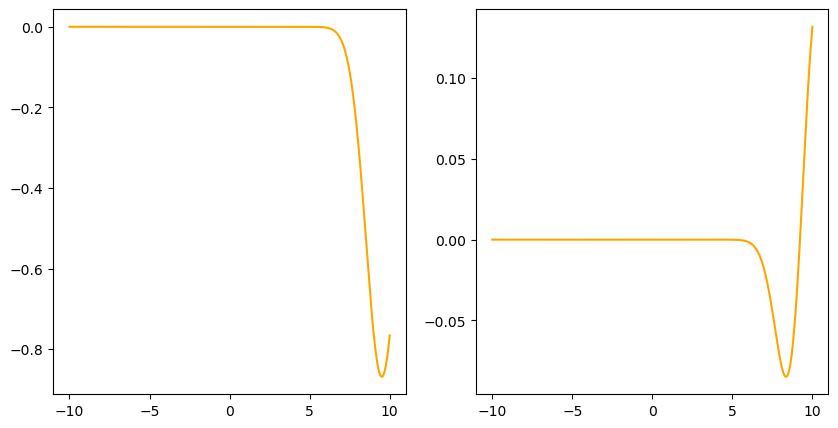

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        
print(f"Wavefunction history size: {len(wave_function_history)}")
with torch.no_grad():
    line, = ax[0].plot(x_train.cpu().numpy(), wave_function_history[0].real, label="NQS", color="orange")
    line2, = ax[1].plot(x_train.cpu().numpy(), wave_function_history[0].imag, label="NQS", color="orange")

In [4]:
from torch_wavefunction import *
Nv = 21
RBM_OHE = WaveFunctionRBM_OHE(Nv, 10)
RBM_OHE.to(device)
x_train = torch.linspace(-10, 10, 100, dtype=torch.float32, device=device)
x_train.requires_grad = True

psi = RBM_OHE(x_train)

print(torch.autograd.grad(psi.sum(), x_train, allow_unused=True)[0])

None
